### Генерация поэзии с помощью нейронных сетей: шаг 1
Основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-05-12 20:08:21--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2024-05-12 20:08:21 (70.1 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

In [ ]:
# seminar implementation

In [6]:
class CharRNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=100, rnn_num_units = 300):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(
            embedding_size + rnn_num_units,
            rnn_num_units
        )
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):

        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        assert h_next.size() == h_prev.size()

        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):

        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [7]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [8]:
def rnn_loop(char_rnn, batch_ix):

    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)

In [9]:
batch_ix = next(generate_chunk())
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens),
                  actual_next_tokens.contiguous().view(-1))
print(loss)

tensor(4.4261, grad_fn=<NllLossBackward0>)


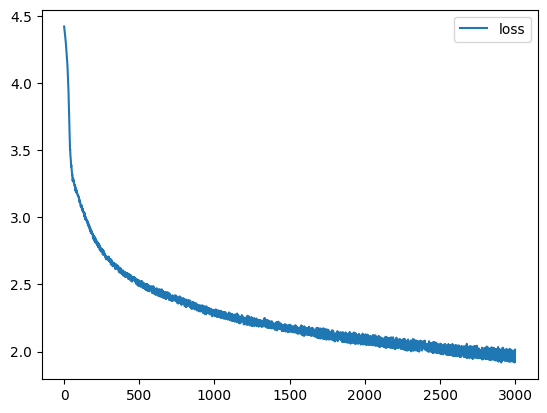

In [21]:
from IPython.display import clear_output

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
history = []

opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-4, amsgrad=True)

for i in range(3000):
    batch_ix = next(generate_chunk())
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    logp_seq = rnn_loop(char_rnn, batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens),
                  actual_next_tokens.contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.numpy()
    history.append(loss.data.numpy())

    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [22]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    hid_state = char_rnn.initial_state(batch_size=1)

    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)

    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [23]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилы
и вздала с васер шам оно.
гостида вижда лече блалиц
стором и не сляда.
провся пленых жернигом зарен?
забыл ленской и постетах,
вдобраткоко с рочого смолучье





xii

и свол он лень верена доло
бедом кредний заделей седь
на видца и расский качет.



«x

вот в седет жисбила на бнадья,
грумиц с няно тары обылать
ое их илько дорозумный,
куки не надвия том;
отерьное гредит голод
и неку был об он утров,
пригодить рунила заброст.



xxvii

но ж же тить продут старинов,



In [24]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилой
стихом твенит невой душой,
как молка татьяна межды,
устали доворь леняню света
татьяна в светит стратая; поры,
предут он ее скродеть?
умил васьмо раздавне мила
и запеетвые ле в не предной
полно сне состознила предвам,
мости в ней он весь меня лен?»



xxxvii. – исерд судью сторона она
и так егда два руда?
«на нетира ты лиспета
и рокорени рокомной,
подился послетоа лепеть,
за севет меря доле соворно?
запесть, ваткика, друг никий;
весто без, молодать нагодной
кочел


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [25]:
generated_phrases = [generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=1.).replace('<sos>', '') for _ in range(10)]

In [26]:
for f in generated_phrases:
  print(f)

 мой дядя самых честных правиле,
зваждой меннули не преди лать.



xxxvi,
тум, татсона лезниу:
я, продултым пилью етру,
кладем вображбак точит
и яс не вnцпрежным дужай,
воздела квой предастростою мнец.
«дель, взорь упраги по равной,
просождых неж него в нем»
как глу, что же снего мица:
сихах нам ричастих ул писум;
девыл я раздаясь; очкою


»el жи-скак дольбо умиданий
(пошей кладном муж довства не был пудца!
дойли ведила пак быле
татьяна пои посужелий,
моей спор, в уг плебы, журки снадата,
погохо
 мой дядя самых честных правиляна,
что как небодь ладова….
«ты верен бечет сторятей сесли
мождала, без с били шино.



xxii

ни: жевлестным одненьем годной прихарт;
и сторет пошлу полары
ятей в теби нокогит,
союный паскаремае.



xxii

«вотя зданьтом гля ул; болненой одно
имца полу стрятны, надают;
кнуг милит… чувских моей
спавать дух таней дат ужул..



vxii

уменит беро замитускою; пыла
дай-ставням и досавствузу,
вбохалко. к когда день моск;
в неце не делгов, на постой
в татьяни празкопидетно

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!